# 1. Predicting Heart Disease Using a Classification Tree

In [2]:
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
df = pd.read_csv(url, header=None, sep=",", na_values="?")
print(df.shape)

(303, 14)


Rename the variables in the following order:
['age', 'sex', 'cp', 'restbp', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'hd'],
and remove missing values.

In [3]:
df.columns = ['age', 'sex', 'cp', 'restbp', 'chol', 'fbs',
              'restecg', 'thalach', 'exang', 'oldpeak',
              'slope', 'ca', 'thal', 'hd']

df = df.dropna().astype(float)

Convert all categorical variables into dummy variables.


In [4]:
categorical_vars = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

df_dummies = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

#Nota:
#pd.get_dummies() creates one column per category (0/1 encoding).
#drop_first=True avoids perfect multicollinearity by removing one category per variable.

Create a binary variable y that equals 1 if the person has heart disease and 0 otherwise.

In [5]:
# 1. Create the binary target variable y
y = (df['hd'] > 0).astype(int)

# 2. Check how many people have / don’t have heart disease
print(y.value_counts())

# 3. Attach y to the dataframe if you want
df['y'] = y

# Display first few rows
df[['hd', 'y']].head()

hd
0    160
1    137
Name: count, dtype: int64


,hd,y
0,0.0,0
1,2.0,1
2,1.0,1
3,0.0,0
4,0.0,0


# Data Analysis

Split the data into training and test sets, and plot a classification tree (random_state = 123).

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Define features (X) and target (y)
X = df.drop(['hd', 'y'], axis=1)   # all predictors
y = df['y']                        # binary target variable

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123
)

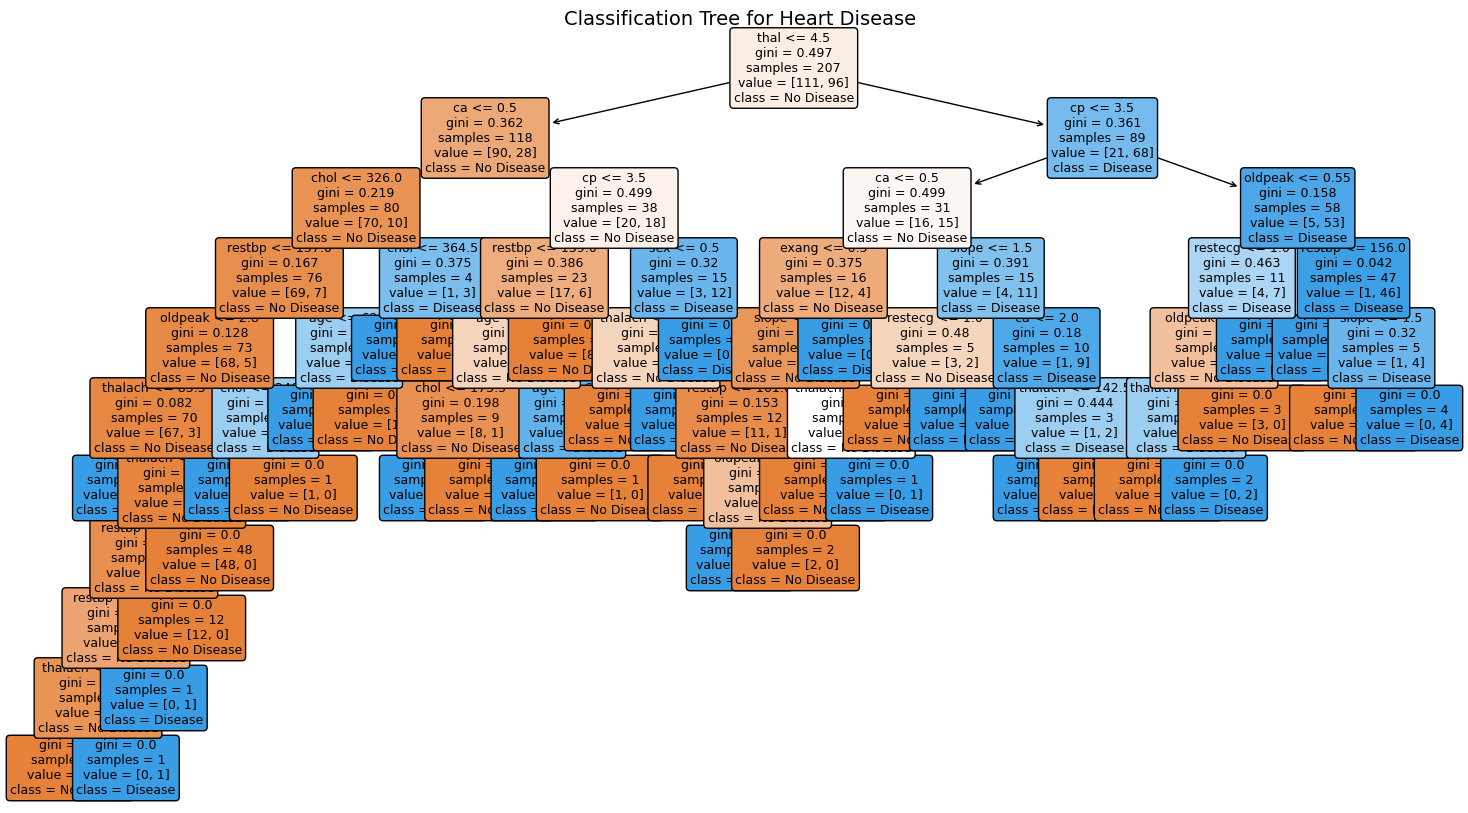

In [7]:
# Initialize and fit the classification tree
tree = DecisionTreeClassifier(random_state=123)
tree.fit(X_train, y_train)

# Plot the classification tree
plt.figure(figsize=(18, 10))
plot_tree(
    tree,
    feature_names=X.columns,
    class_names=['No Disease', 'Disease'],
    filled=True,
    rounded=True,
    fontsize=9
)
plt.title("Classification Tree for Heart Disease", fontsize=14)
plt.show()

Plot the confusion matrix using the labels ["Does not have HD", "Has HD"] and interpret the results.

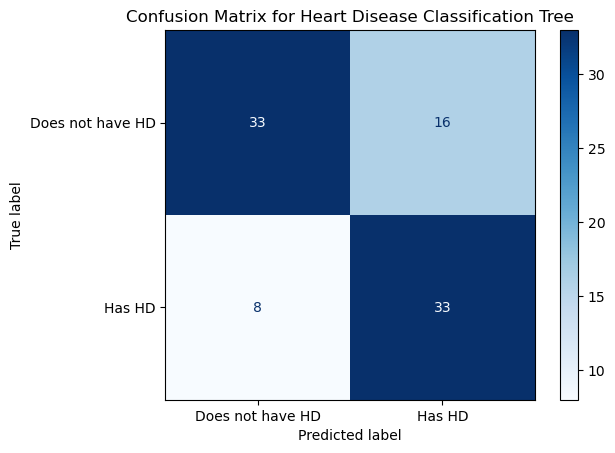

Accuracy: 0.733


In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Make predictions on the test set
y_pred = tree.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
labels = ["Does not have HD", "Has HD"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Heart Disease Classification Tree")
plt.show()

# Print accuracy
print("Accuracy:", accuracy_score(y_test, y_pred).round(3))

The classification tree predicts whether someone has heart disease with 73% accuracy — meaning it gets about 3 out of 4 people right.
- 33 people were correctly predicted as healthy.
- 33 people were correctly predicted as having heart disease.
- 16 people were predicted to have the disease but actually don’t (false alarms).
- 8 people were predicted as healthy but actually have the disease (missed cases).

So the model does a good job overall, but it still misses some real cases and sometimes raises unnecessary alerts.

- Fix the overfitting problem using ross-validation.
- Generate 50 values of α equally spaced on a logarithmic scale between e⁻¹⁰ and 0.05.
- Use 4-fold cross-validation to select the optimal alpha (random_state = 123).

In [11]:
# Generate 50 values of alpha equally spaced on a logarithmic scale
alphas = np.logspace(np.log10(np.exp(-10)), np.log10(0.05), 50)
alphas

array([4.53999298e-05, 5.23763313e-05, 6.04247649e-05, 6.97099649e-05,
       8.04219795e-05, 9.27800608e-05, 1.07037153e-04, 1.23485067e-04,
       1.42460458e-04, 1.64351711e-04, 1.89606894e-04, 2.18742927e-04,
       2.52356162e-04, 2.91134590e-04, 3.35871924e-04, 3.87483841e-04,
       4.47026728e-04, 5.15719301e-04, 5.94967550e-04, 6.86393518e-04,
       7.91868501e-04, 9.13551347e-04, 1.05393265e-03, 1.21588570e-03,
       1.40272535e-03, 1.61827580e-03, 1.86694891e-03, 2.15383450e-03,
       2.48480449e-03, 2.86663314e-03, 3.30713567e-03, 3.81532823e-03,
       4.40161244e-03, 5.07798829e-03, 5.85829975e-03, 6.75851813e-03,
       7.79706900e-03, 8.99520928e-03, 1.03774624e-02, 1.19721200e-02,
       1.38118214e-02, 1.59342215e-02, 1.83827611e-02, 2.12075568e-02,
       2.44664260e-02, 2.82260708e-02, 3.25634433e-02, 3.75673201e-02,
       4.33401201e-02, 5.00000000e-02])

In [17]:
# Store mean CV accuracy for each alpha
cv_scores = []

for a in alphas:
    tree_cv = DecisionTreeClassifier(random_state=123, ccp_alpha=a) # Creates a new decision tree model for each α value.
    scores = cross_val_score(tree_cv, X_train, y_train, cv=4) # Performs 4-fold cross-validation on the training data for that specific α
    cv_scores.append(scores.mean()) # Calculates the mean accuracy across the 4 folds for that α and saves it in the list cv_scores.
 
# Notes:
# Small α → almost no pruning (complex tree, risk of overfitting)
# Large α → aggressive pruning (simpler tree, risk of underfitting)

In [18]:
# Select best alpha
best_alpha = alphas[np.argmax(cv_scores)]
print("Best alpha:", best_alpha)
print("Best mean CV accuracy:", max(cv_scores))

Best alpha: 0.018382761127718174
Best mean CV accuracy: 0.7633861236802413


Plot the Inaccuracy Rate (1 − Accuracy) against alpha.

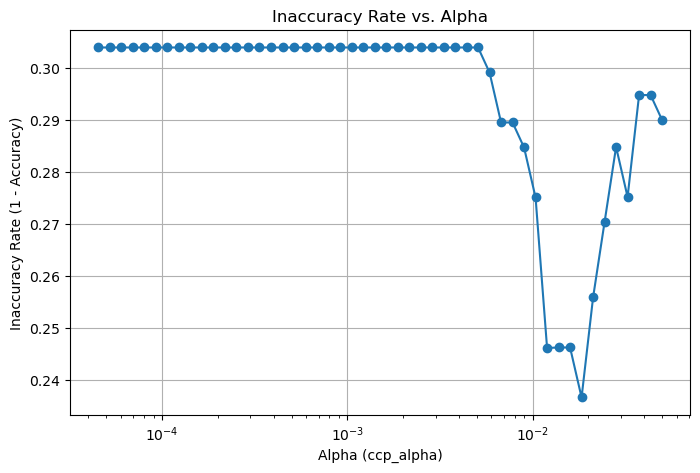

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Compute inaccuracy = 1 - accuracy for each alpha
inaccuracy = 1 - np.array(cv_scores)

# Plot
plt.figure(figsize=(8,5))
plt.plot(alphas, inaccuracy, marker='o')
plt.xscale('log')  # log scale for alpha
plt.xlabel("Alpha (ccp_alpha)")
plt.ylabel("Inaccuracy Rate (1 - Accuracy)")
plt.title("Inaccuracy Rate vs. Alpha")
plt.grid(True)
plt.show()

Plot again the classification tree and the confusion matrix using the optimal α. Interpret and briefly discuss the results.

In [20]:
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Train the pruned tree using the optimal alpha
pruned_tree = DecisionTreeClassifier(random_state=123, ccp_alpha=best_alpha)
pruned_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.018382761127718174, random_state=123)

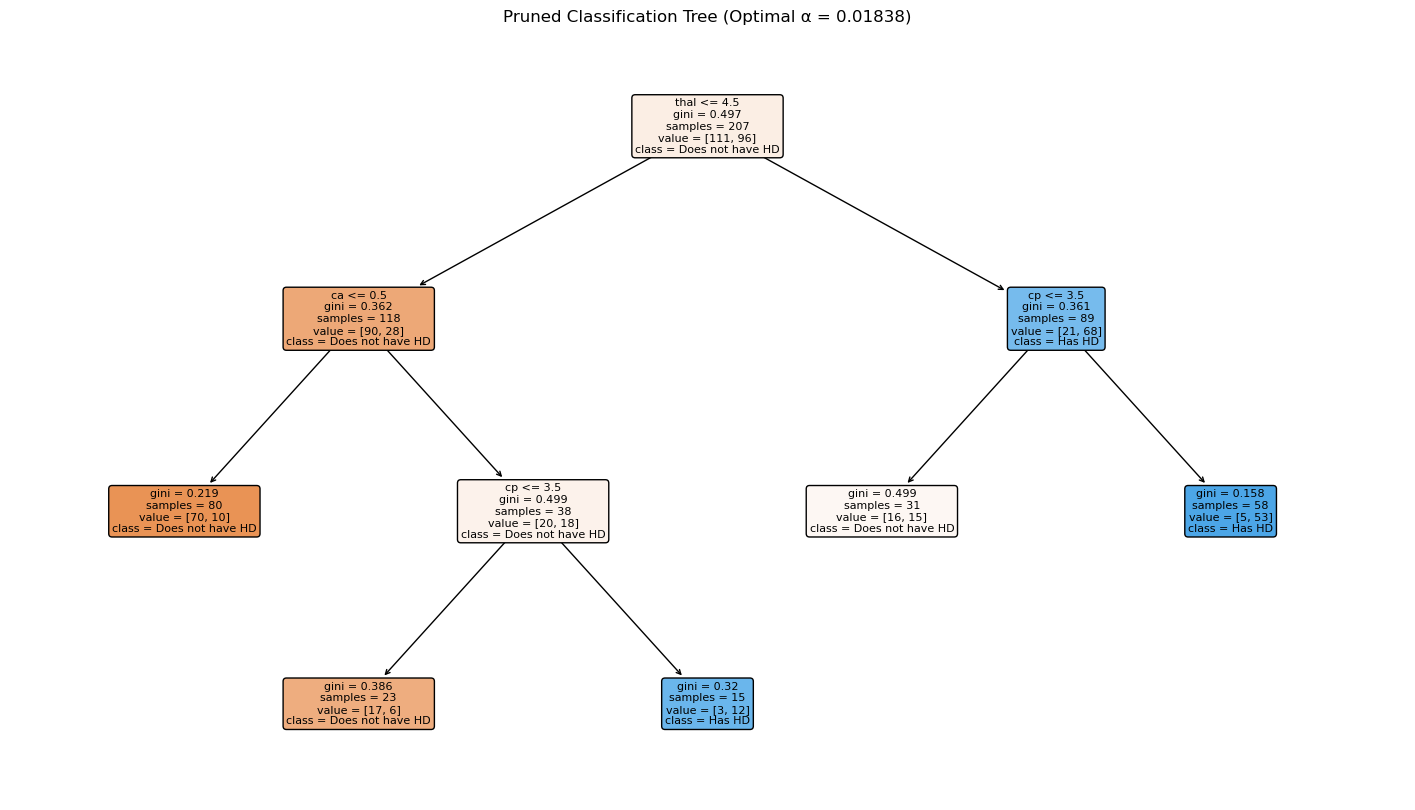

In [21]:
# Plot the pruned classification tree
plt.figure(figsize=(18, 10))
plot_tree(pruned_tree, filled=True, rounded=True, 
          feature_names=X.columns, class_names=["Does not have HD", "Has HD"],
          fontsize=8)
plt.title(f"Pruned Classification Tree (Optimal α = {best_alpha:.5f})")
plt.show()

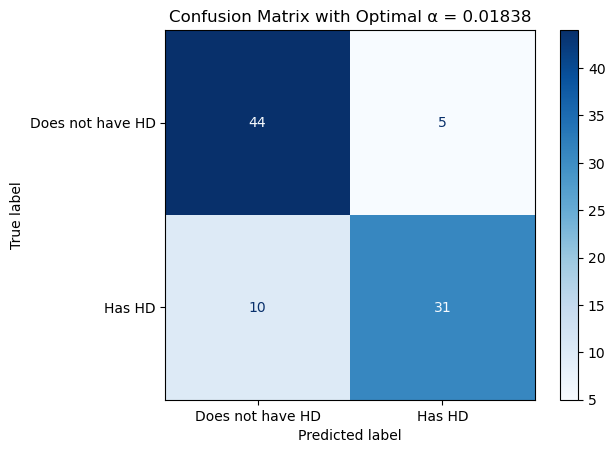

Test Accuracy: 0.833


In [23]:
# Predict and plot confusion matrix
y_pred = pruned_tree.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Does not have HD", "Has HD"])
disp.plot(cmap="Blues", values_format='d')
plt.title(f"Confusion Matrix with Optimal α = {best_alpha:.5f}")
plt.show()

# Print test accuracy
print("Test Accuracy:", round(accuracy_score(y_test, y_pred), 3))

Interpretation:
- After applying cost-complexity pruning with cross-validation, the optimal α reduced the depth of the tree.
- The pruned classification tree correctly predicted 83% of all cases, a clear improvement from the previous unpruned model (which had ~73% accuracy).
- This suggests that pruning successfully reduced overfitting, helping the model generalize better to unseen data.